<a href="https://colab.research.google.com/github/ldockx/my-first-data-engineering-project/blob/first-notebook-upload/first_data_engineering_effort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

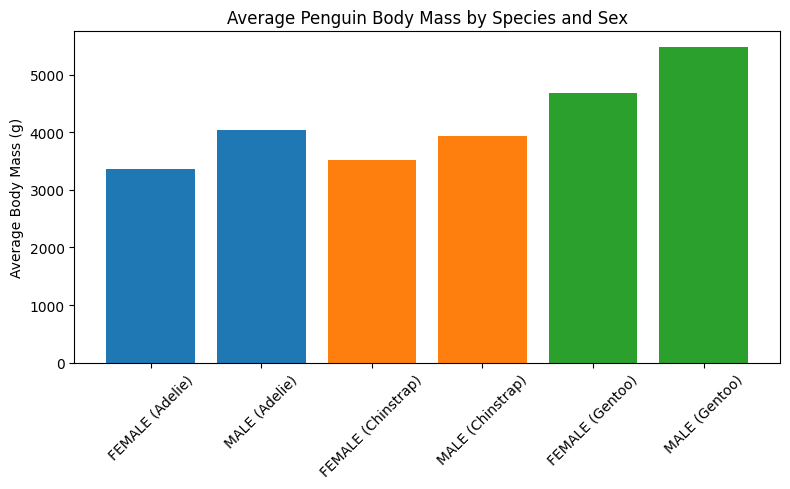

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Extract: Load penguin dataset from GitHub (public CSV)
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
df = pd.read_csv(url)

# 2. Transform: Clean missing values & compute mean body mass by species and sex
df_clean = df.dropna(subset=["body_mass_g", "sex"])
grouped = df_clean.groupby(["species", "sex"])["body_mass_g"].mean().reset_index()

# 3. Visualize: Plot grouped averages
plt.figure(figsize=(8,5))
for species in grouped["species"].unique():
    subset = grouped[grouped["species"] == species]
    plt.bar(subset["sex"] + " (" + species + ")", subset["body_mass_g"], label=species)

plt.ylabel("Average Body Mass (g)")
plt.title("Average Penguin Body Mass by Species and Sex")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
